# PSEUDo convergence test

In this experiment we will test the convergence of our algorithm

We first load the EEG data and convert it to a numpy array

In [1]:
import numpy as np
import os
from generator import generate_dataset

import numpy as np
import os
from generator import generate_dataset

data_path = 'data/processed-data.npy'

if not os.path.isfile(data_path):
    print("Generating dataset")
    generate_dataset()
original_data = np.load(data_path, allow_pickle=True)
print("Dataset loaded")

print(original_data.shape)

Dataset loaded
(10000,)


In [2]:
data = np.array(list(map(lambda sample: sample['ts'], original_data)))
print(data.shape)

(10000, 120, 3)


Next, the data is cut into subwindows of size T. We use a stepsize of T/8. Because of memory issues, only 40 of the 70 channels are used for this experiment.

In [3]:
from sklearn import preprocessing

N = 3
T = 120
nr_of_targets = 5
nr_of_iterations = 5
nr_of_candidates = 100
print(data.shape)

(10000, 120, 3)


We sample a number of subwindows which will be used as query for the search algorithms

In [4]:
import random

#[2291, 6969, 1172, 1615, 1592]
targets = [2291, 6969, 1172, 1615, 1592] #random.sample(list(range(len(data))), nr_of_targets)
target_channels = [0,1,2]
print(targets)
print(target_channels)

[2291, 6969, 1172, 1615, 1592]
[0, 1, 2]


For the LSH algorithm some preprocessing is done to find the right LSH parameters.

In [5]:
import sys
from time import time

sys.path.insert(0, '../Flaskserver')
import importlib
from pseudo import preprocess, lsh
import _lsh

topk_dtw = []

print('Preprocessing:')
t0 = time()
r,a,sd = preprocess(data, data.shape[2])
print('Preprocessing done. Took {:.2f} seconds ({:.1f} minutes).'.format(time() - t0, (time() - t0) / 60))

Preprocessing:
r = 3
bigger
r = 7.5
Mean: 10.155461598470655
Stdev: 1.5982142225957707
Ratio mean: 0.9780438987235948
Ratio stdev: 0.02061614365827334
Theta: 6.032068904173567
r: 0.5751348147439628
Preprocessing time: 3.1081292629241943
Preprocessing done. Took 3.11 seconds (0.1 minutes).


For all queries we do a few iterations whilst applying a fabricated weight vector.

In [6]:
from tslearn.metrics import dtw
from time import time
import math

alpha = 0.25
weights = [1] * N
new_weights = [0.3, -0.1, -0.2]

output_validation = []
output = []
initial_candidates = []
final_candidates = []

for iteration in range(nr_of_iterations):
    t0 = time()
    iteration_list = []
    for i, target in enumerate(targets):
        t1 = time()
        query = data[target]
        response = lsh(data, query, [r, a, sd], weights)
        candidates = response['average_candidates']
        print('Target #{} done! Took {:.2f} seconds ({:.1f} minutes).'.format(i, time() - t1, (time() - t1) / 60))
            
        candidate_list = []
        for channel in target_channels:
            channel_distance = 0
            for candidate in candidates[1:nr_of_candidates+1]:
                channel_distance += (dtw(data[candidate][:,channel], query[:,channel], global_constraint='sakoe_chiba', sakoe_chiba_radius=int(0.05 * T)))
            candidate_list.append(channel_distance/nr_of_candidates)
        iteration_list.append(candidate_list)
    output_validation.append(iteration_list)    
    print('Iteration ' + str(iteration) + ' completed')

for iteration in range(nr_of_iterations):
    t0 = time()
    iteration_list = []
    for i, target in enumerate(targets):
        t1 = time()
        query = data[target]
        response = lsh(data, query, [r, a, sd], weights)
        candidates = response['average_candidates']
        print('Target #{} done! Took {:.2f} seconds ({:.1f} minutes).'.format(i, time() - t1, (time() - t1) / 60))
        
        if iteration == 0:
            initial_candidates.append(candidates[1:nr_of_candidates+1])
        if iteration == nr_of_iterations-1:
            final_candidates.append(candidates[1:nr_of_candidates+1])
            
        candidate_list = []
        for channel in target_channels:
            channel_distance = 0
            for candidate in candidates[1:nr_of_candidates+1]:
                channel_distance += (dtw(data[candidate][:,channel], query[:,channel], global_constraint='sakoe_chiba', sakoe_chiba_radius=int(0.05 * T)))
            candidate_list.append(channel_distance/nr_of_candidates)
        iteration_list.append(candidate_list)
    output.append(iteration_list)    
    weights = alpha * np.array(weights) + (1 - alpha) * np.sqrt(np.array([1,1,1]) + (iteration+1) * np.array(new_weights))
    print(weights)
    print('Iteration ' + str(iteration) + ' completed')

Target #0 done! Took 0.23 seconds (0.0 minutes).
Target #1 done! Took 0.25 seconds (0.0 minutes).
Target #2 done! Took 0.22 seconds (0.0 minutes).
Target #3 done! Took 0.20 seconds (0.0 minutes).
Target #4 done! Took 0.39 seconds (0.0 minutes).
Iteration 0 completed
Target #0 done! Took 0.38 seconds (0.0 minutes).
Target #1 done! Took 0.54 seconds (0.0 minutes).
Target #2 done! Took 0.42 seconds (0.0 minutes).
Target #3 done! Took 0.24 seconds (0.0 minutes).
Target #4 done! Took 0.27 seconds (0.0 minutes).
Iteration 1 completed
Target #0 done! Took 0.25 seconds (0.0 minutes).
Target #1 done! Took 0.18 seconds (0.0 minutes).
Target #2 done! Took 0.16 seconds (0.0 minutes).
Target #3 done! Took 0.37 seconds (0.0 minutes).
Target #4 done! Took 0.21 seconds (0.0 minutes).
Iteration 2 completed
Target #0 done! Took 0.15 seconds (0.0 minutes).
Target #1 done! Took 0.15 seconds (0.0 minutes).
Target #2 done! Took 0.16 seconds (0.0 minutes).
Target #3 done! Took 0.24 seconds (0.0 minutes).
Tar

In [7]:
print(weights)

[1.54771439 0.72902288 0.12617316]


We plot the DTW distance per channel

In [8]:
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure

# figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

new_validation = np.zeros((len(output_validation[0]), len(output_validation[0][0]), len(output_validation)))
x = list(range(len(output_validation)))
for i, iteration in enumerate(output_validation):
    for j, target in enumerate(iteration):
        for k, channel in enumerate(target):
            new_validation[j][k][i] = channel

new = np.zeros((len(output[0]), len(output[0][0]), len(output)))
x = list(range(len(output)))
for i, iteration in enumerate(output):
    for j, target in enumerate(iteration):
        for k, channel in enumerate(target):
            new[j][k][i] = channel

# colors = ['orange', 'green', 'blue', 'black']
# for target in new:
#     for i, channel in enumerate(target):
#         plt.plot(x, channel, label = str(i), color=colors[i])
        
# plt.title('Convergence of important channels')
# plt.legend(loc="lower right")
# plt.show()

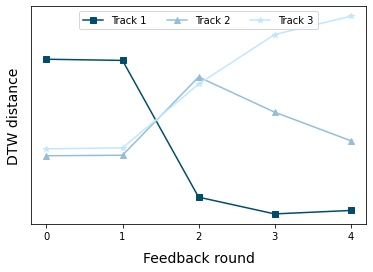

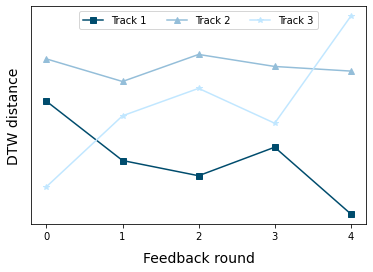

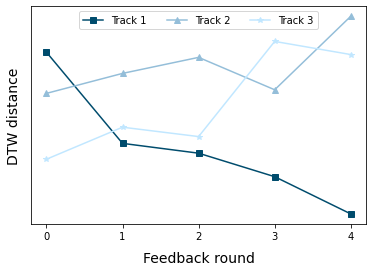

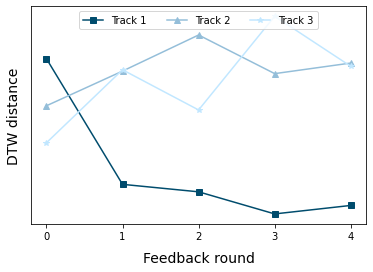

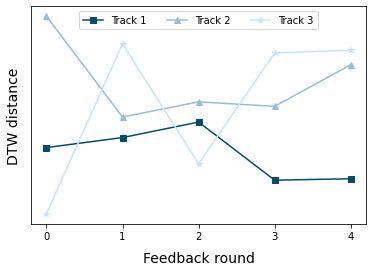

In [13]:
colors = ['#004c6d', '#94bed9', '#c1e7ff']
shape = ['s', '^', '*']



for target in range(nr_of_targets):
    fig, ax = plt.subplots()

    fig.set_size_inches(6, 4)
    plt.yticks([], [])
    plt.xticks(x)
    for i, channel in enumerate(new[target]):
        ax.plot(x, channel, label='Track ' + str(i+1), color=colors[i], marker=shape[i])
    ax.legend(loc=9, ncol=3)
    ax.set_xlabel('Feedback round', labelpad=10, fontsize=14)
    ax.set_ylabel('DTW distance', labelpad=10, fontsize=14)

#     plt.savefig('images/convergence_' + str(target))
    plt.show()

In [10]:
def minmax(windows):
    return np.array(windows).min(axis=0), np.array(windows).max(axis=0)

def stdev(windows):
    return np.mean(windows, axis=0) - np.std(windows, axis=0), np.mean(windows, axis=0) + np.std(windows, axis=0)

For each target, we plot the top-5 windows (query window not included) to display the convergence of our algorithm

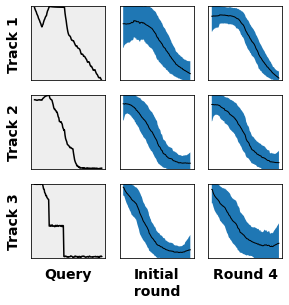

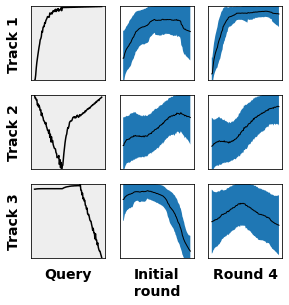

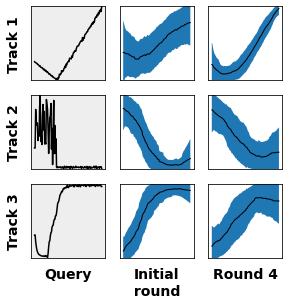

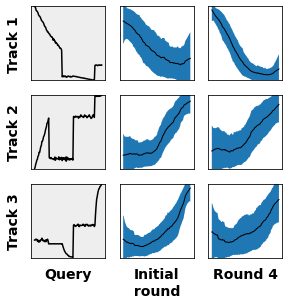

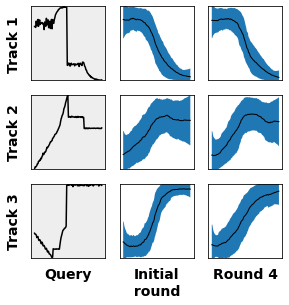

In [14]:
columns = 3
rows = 3
ymax = 1.0

for target in range(nr_of_targets):
    plt.figure(figsize=(1.5 * rows, 1.5 * columns))
    for d, channel in enumerate(target_channels):
        ax = plt.subplot(rows, columns, 1 + columns*d)
        if (d == 2):
            ax.set_xlabel('Query', fontweight='bold', labelpad=10, fontsize=14)
        ax.set_ylabel('Track ' + str(channel+1), fontsize=14, labelpad=10, fontweight='bold')
        ax.set_facecolor("#eeeeee")
        plt.plot(np.arange(T), data[targets[target]][:,channel], color='#000000')

        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])

        ax = plt.subplot(rows, columns, 2 + columns*d)
        if (d == 2):
            ax.set_xlabel('Initial\n round ', labelpad=10, fontweight='bold', fontsize=14)
        y1, y2 = stdev(data[initial_candidates[target]][:,:,channel])
        ax.fill_between(np.arange(T), y1, y2)
        ax.plot(np.arange(T), np.mean(data[initial_candidates[target]][:,:,channel], axis=0), color='#000000', linewidth=1)
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.subplots_adjust(top=0.9)

        ax = plt.subplot(rows, columns, 3 + columns*d)
        if (d == 2):
            ax.set_xlabel('Round 4', fontweight='bold', labelpad=10, fontsize=14)
        y1, y2 = stdev(data[final_candidates[target]][:,:,channel])
        ax.fill_between(np.arange(T), y1, y2)
        ax.plot(np.arange(T), np.mean(data[final_candidates[target]][:,:,channel], axis=0), color='#000000', linewidth=1)
        plt.ylim(0, ymax)
        plt.xticks([], [])
        plt.yticks([], [])
        plt.subplots_adjust(top=0.9)
#     plt.savefig('images/convergence_examples_' + str(target))